RMSE del modelo en el conjunto de entrenamiento: 2.4520098775399046
RMSE del modelo en el conjunto de prueba: 4.734758116717365


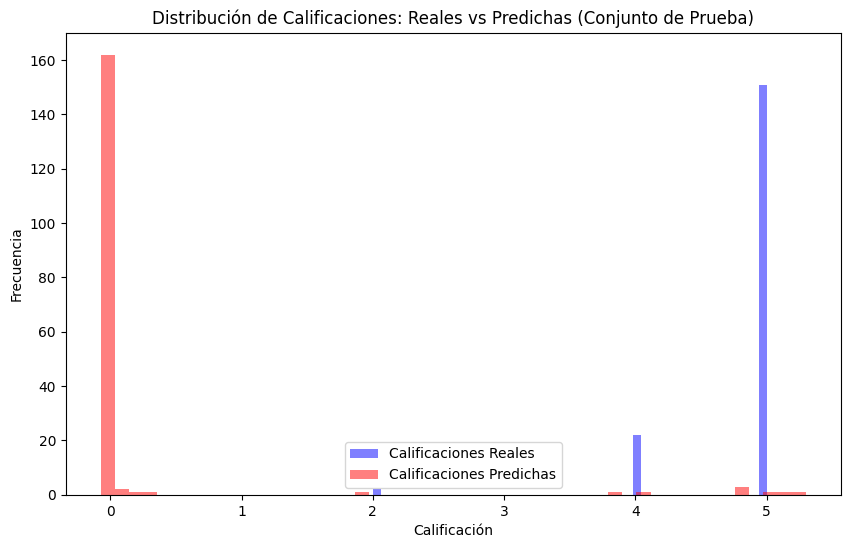

Libros recomendados para A H Kobayashi:
The Shadow Work Journal: A Guide to Integrate and Transcend your Shadows             4.337859e-15
I Love You to the Moon and Back                                                      2.571412e-15
The Four Agreements: A Practical Guide to Personal Freedom (A Toltec Wisdom Book)    2.185000e-15
Killers of the Flower Moon: The Osage Murders and the Birth of the FBI               1.266287e-15
Outlive: The Science and Art of Longevity                                            1.147499e-15
Name: A H Kobayashi, dtype: float64


In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar los datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Crear la matriz usuario-libro a partir de train_df
user_book_matrix = train_df.pivot_table(index='reviewer', columns='book_title', values='reviewer_rating')

# Calcular el promedio de calificaciones por cada libro
book_rating_means = user_book_matrix.mean()

# Llenar los valores faltantes con el promedio de las calificaciones del libro
user_book_matrix_filled = user_book_matrix.apply(lambda row: row.fillna(book_rating_means))

# Obtener las columnas que representan los géneros
genre_columns = [col for col in train_df.columns if col.startswith('genre_')]

# Crear una matriz que combine los géneros de los libros
book_genres_matrix = train_df.groupby('book_title')[genre_columns].first()

# Concatenar la matriz de géneros con la matriz de calificaciones de libros
user_book_genre_matrix_filled = pd.concat([user_book_matrix_filled, book_genres_matrix], axis=1)

# Asegurarse de que no haya NaN ni infinitos en la matriz
user_book_genre_matrix_filled = user_book_genre_matrix_filled.replace([np.inf, -np.inf], np.nan)
user_book_genre_matrix_filled = user_book_genre_matrix_filled.fillna(0)  # Reemplazar NaNs por 0

# Asegurarse de que los valores son de tipo float
user_book_genre_matrix_filled = user_book_genre_matrix_filled.astype(float)

# Aplicar SVD
U, sigma, Vt = svds(user_book_genre_matrix_filled.values, k=50)

# Convertir sigma a una matriz diagonal
sigma = np.diag(sigma)

# Reconstruir la matriz de calificaciones
predicted_ratings_matrix = np.dot(np.dot(U, sigma), Vt)

# Convertir la matriz reconstruida en un DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings_matrix, 
                                    index=user_book_genre_matrix_filled.index, 
                                    columns=user_book_genre_matrix_filled.columns)

# Mostrar las primeras filas de las predicciones
predicted_ratings_df.head()

# Seleccionar solo las columnas de los libros en la matriz de predicciones (excluyendo los géneros)
book_columns = user_book_matrix_filled.columns
train_predicted_books = predicted_ratings_df[book_columns].reindex(user_book_matrix_filled.index).fillna(0).values

# Calcular RMSE (Root Mean Squared Error) asegurándonos de no tener NaNs
def rmse(predicted, actual):
    # Reemplazar NaNs por 0 en las matrices predichas y reales
    predicted = np.nan_to_num(predicted)
    actual = np.nan_to_num(actual)

    # Filtrar los valores que no son 0 en la matriz real
    predicted_flat = predicted[actual != 0]
    actual_flat = actual[actual != 0]

    return np.sqrt(mean_squared_error(actual_flat, predicted_flat))

# Obtener las calificaciones reales y predichas del conjunto de entrenamiento
train_actual = user_book_matrix_filled.values

# Calcular el RMSE en el conjunto de entrenamiento
print(f"RMSE del modelo en el conjunto de entrenamiento: {rmse(train_predicted_books, train_actual)}")

# Obtener las calificaciones reales y predichas del conjunto de prueba
test_user_book_matrix = test_df.pivot_table(index='reviewer', columns='book_title', values='reviewer_rating')
test_user_book_matrix_filled = test_user_book_matrix.fillna(0)
test_predicted = predicted_ratings_df.reindex(test_user_book_matrix_filled.index).fillna(0)[test_user_book_matrix_filled.columns].fillna(0).values

# Calcular el RMSE en el conjunto de prueba
test_actual = test_user_book_matrix_filled.values
print(f"RMSE del modelo en el conjunto de prueba: {rmse(test_predicted, test_actual)}")

# Histograma para comparar las calificaciones reales y las predichas en el conjunto de prueba
plt.figure(figsize=(10,6))
plt.hist(test_actual[test_actual != 0].flatten(), bins=50, alpha=0.5, label='Calificaciones Reales', color='blue')
plt.hist(test_predicted[test_actual != 0].flatten(), bins=50, alpha=0.5, label='Calificaciones Predichas', color='red')
plt.title('Distribución de Calificaciones: Reales vs Predichas (Conjunto de Prueba)')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Función para obtener recomendaciones para un usuario
def get_top_recommendations(user_id, original_ratings_matrix, predicted_ratings_matrix, num_recommendations=5):
    # Obtener los libros que el usuario ya ha calificado
    user_rated_books = original_ratings_matrix.loc[user_id].dropna().index.tolist()
    
    # Obtener las predicciones para ese usuario
    user_predictions = predicted_ratings_matrix.loc[user_id].sort_values(ascending=False)
    
    # Filtrar los libros que el usuario no ha calificado
    recommendations = user_predictions[~user_predictions.index.isin(user_rated_books)].head(num_recommendations)
    
    return recommendations

# Ejemplo de uso: Obtener recomendaciones para un usuario específico
example_user = "A H Kobayashi"
top_recommendations = get_top_recommendations(example_user, user_book_matrix, predicted_ratings_df)

# Mostrar las recomendaciones
print(f"Libros recomendados para {example_user}:")
print(top_recommendations)